In [120]:
import pandas as pd
import numpy as np
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report, f1_score
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from randomforest import RandomForestDrift
from psi import calculate_psi

In [121]:
filename = "data/diabetes/pima-indians-diabetes.csv"
ycolumn = "Outcome"
col_names = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age', 'label']
df = pd.read_csv(filename, header=None, skiprows=1, names=col_names)
#split dataset in features and target variable
feature_cols = ['pregnant', 'insulin', 'bmi', 'age','glucose','bp','pedigree']
X = df[feature_cols] # Features
y = df.label # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state = 42,
                                                    stratify = y)
# data_prep = DataPreparation(filename, ycolumn)
# X, y = data_prep.load_dataset_file()
# X_train, X_test, y_train, y_test = data_prep.split_train_test(X, y)
    

In [122]:
def show_psi(y_pred, y_pred_drift):
    y_pred = np.vectorize({False: 0, True: 1}.get)(y_pred)
    y_pred_drift = np.vectorize({False: 0, True: 1}.get)(y_pred_drift)
    psi_diff = calculate_psi(y_pred, y_pred_drift, buckets=2, axis=1)
    print("PSI Difference:", psi_diff)

def show_confusion_matrix(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)

In [123]:
# Initialize the RandomForestDrift class
rf_drift = RandomForestDrift(n_estimators=410, max_depth=5)
# rf_drift = RandomForestClassifier(n_estimators = 50, random_state = 42)
# Fit the model
rf_drift.fit(X_train, y_train)
# Make predictions
y_pred = rf_drift.predict(X_test)

# Show confusion matrix
print("--------no drift--------")
rf_drift.show_confusion_matrix(y_test, y_pred)

# Make data quality drift predictions
X_test_drift = rf_drift.data_drift_injection(X_test, column_name="glucose")
y_pred_drift = rf_drift.predict(X_test_drift)
X_test_quality = rf_drift.data_quality_injection(X_test, column_name="glucose")
y_pred_quality = rf_drift.predict(X_test_quality)
print("----------data quality--------")
rf_drift.show_psi(y_pred, y_pred_quality)
rf_drift.show_confusion_matrix(y_test, y_pred_quality)
print("----------data drift--------")
rf_drift.show_psi(y_pred, y_pred_drift)
rf_drift.show_confusion_matrix(y_test, y_pred_drift)

--------no drift--------
Accuracy: 0.7402597402597403
Precision: 0.6666666666666666
Recall: 0.5185185185185185
----------data quality--------
PSI Difference: 0.26419777348858603
Accuracy: 0.7207792207792207
Precision: 0.9230769230769231
Recall: 0.2222222222222222
----------data drift--------
PSI Difference: 0.6522950898614043
Accuracy: 0.6753246753246753
Precision: 1.0
Recall: 0.07407407407407407


In [124]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, param_distributions = param_dist , n_iter=5, cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7607d1e44d70>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7607d49e34a0>})

In [125]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)
# Generate predictions with the best model
y_pred_best = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_best)
precision = precision_score(y_test, y_pred_best)
recall = recall_score(y_test, y_pred_best)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Best hyperparameters: {'max_depth': 15, 'n_estimators': 134}
Accuracy: 0.7597402597402597
Precision: 0.6888888888888889
Recall: 0.5740740740740741


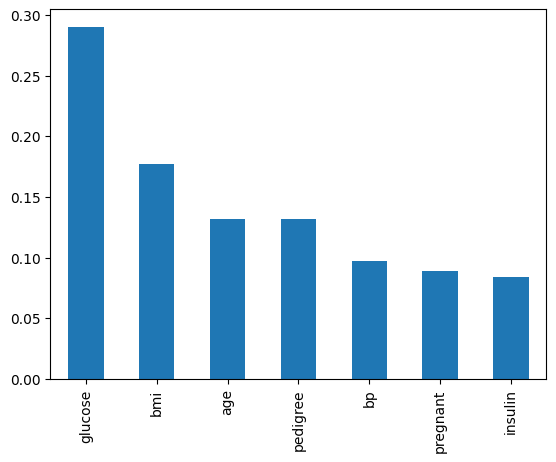

In [126]:
# Create a series contain feature importances from the model and feature names from the training data
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();

In [127]:
# from psi import calculate_psi
# calculate_psi(X_test['expenditure'], X_test_drift['expenditure'], buckets=24, axis=1)

## Data Drift -> Model Drift

In [128]:
import numpy as np
import pandas as pd
num_iterations = 200
sample_size = 50

# Store results for each iteration
X_results = []
y_results = []

df_X = pd.DataFrame(columns=X_test.columns)
arr_y = np.array([])

for i in range(1, num_iterations + 1):
    if i <= 100:
        # First 100 iterations: Choose from X_test and y_pred
        random_indices = np.random.choice(len(y_pred), size=sample_size, replace=False)
        X_sample = X_test.iloc[random_indices]
        y_sample = y_pred[random_indices]
        # print(type(X_sample))
        # print(type(y_sample))
    elif 101 <= i <= 110:
        # Iterations 101-110: Choose from X_test_drift and y_pred_drift
        random_indices = np.random.choice(len(y_pred_drift), size=sample_size, replace=False)
        X_sample = X_test_drift.iloc[random_indices]
        y_sample = y_pred_drift[random_indices]
    else:
        # Iterations 111-200: Choose from X_test and y_pred
        random_indices = np.random.choice(len(y_pred), size=sample_size, replace=False)
        X_sample = X_test.iloc[random_indices]
        y_sample = y_pred[random_indices]

    df_X = pd.concat([df_X, X_sample], ignore_index=True)
    arr_y = np.append(arr_y, y_sample)


/tmp/ipykernel_2342261/2633098599.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_X = pd.concat([df_X, X_sample], ignore_index=True)


In [129]:
len(df_X)
len(arr_y)

10000

In [130]:
window_size = 300
psi_values = []

results = arr_y
# Check if results array has enough data
if len(results) < window_size:
    print("Not enough data in results for sliding window.")
else:
    # Sliding window loop
    for start in range(len(results) - window_size + 1):
        # Get the current window
        window = results[start:start + window_size]
        
        # Extract expected and actual values
        expected = window[:window_size // 2]  # First half of the window
        actual = window[window_size // 2:]   # Second half of the window
        
        # Debugging: Check sizes
        # print(f"Processing window starting at index {start}")
        # print(f"Expected size: {len(expected)}, Actual size: {len(actual)}")
        
        # Calculate PSI for the current window
        psi_value = calculate_psi(expected, actual, buckets=2, axis=0)
        psi_values.append(psi_value)

# Print or process the PSI values
# print("PSI values for sliding windows:", psi_values)

/home/tingdai/code/BCBS_models/psi.py:36: RuntimeWarning: divide by zero encountered in scalar divide
  input /= np.max(input) / (max - min)


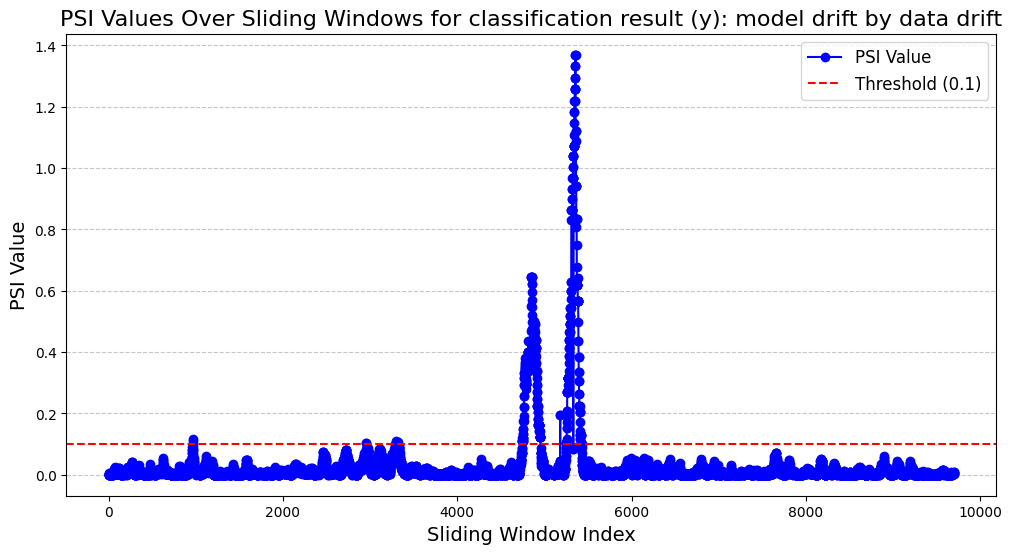

In [131]:
import matplotlib.pyplot as plt

# Assuming psi_values is already calculated
plt.figure(figsize=(12, 6))
plt.plot(range(len(psi_values)), psi_values, marker='o', linestyle='-', color='b', label='PSI Value')
plt.title('PSI Values Over Sliding Windows for classification result (y): model drift by data drift', fontsize=16)
plt.xlabel('Sliding Window Index', fontsize=14)
plt.ylabel('PSI Value', fontsize=14)
plt.axhline(y=0.1, color='r', linestyle='--', label='Threshold (0.1)')
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [132]:
window_size = 300
psi_values = []

results = df_X['glucose']
# Check if results array has enough data
if len(results) < window_size:
    print("Not enough data in results for sliding window.")
else:
    # Sliding window loop
    for start in range(len(results) - window_size + 1):
        # Get the current window
        window = results[start:start + window_size]
        
        # Extract expected and actual values
        expected = window[:window_size // 2]  # First half of the window
        actual = window[window_size // 2:]   # Second half of the window
        
        # Debugging: Check sizes
        # print(f"Processing window starting at index {start}")
        # print(f"Expected size: {len(expected)}, Actual size: {len(actual)}")
        
        # Calculate PSI for the current window
        psi_value = calculate_psi(expected, actual, buckets=10, axis=0)
        psi_values.append(psi_value)

# Print or process the PSI values
# print("PSI values for sliding windows:", psi_values)

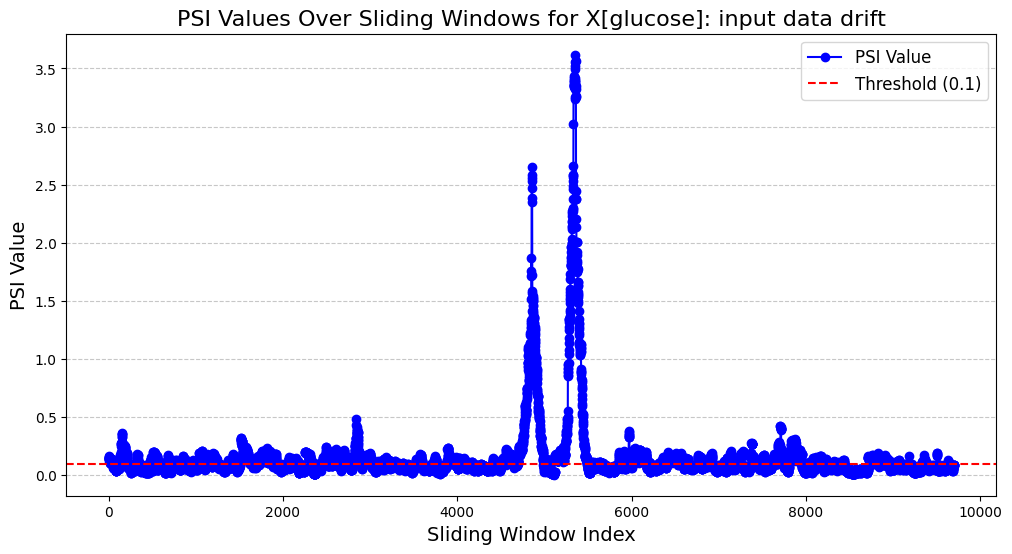

In [133]:
import matplotlib.pyplot as plt

# Assuming psi_values is already calculated
plt.figure(figsize=(12, 6))
plt.plot(range(len(psi_values)), psi_values, marker='o', linestyle='-', color='b', label='PSI Value')
plt.title('PSI Values Over Sliding Windows for X[glucose]: input data drift', fontsize=16)
plt.xlabel('Sliding Window Index', fontsize=14)
plt.ylabel('PSI Value', fontsize=14)
plt.axhline(y=0.1, color='r', linestyle='--', label='Threshold (0.1)')
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Data Quality -> Model Drift

In [134]:
import numpy as np
import pandas as pd
num_iterations = 200
sample_size = 50

# Store results for each iteration
X_results = []
y_results = []

df_X = pd.DataFrame(columns=X_test.columns)
arr_y = np.array([])

for i in range(1, num_iterations + 1):
    if i <= 100:
        # First 100 iterations: Choose from X_test and y_pred
        random_indices = np.random.choice(len(y_pred), size=sample_size, replace=False)
        X_sample = X_test.iloc[random_indices]
        y_sample = y_pred[random_indices]
        # print(type(X_sample))
        # print(type(y_sample))
    elif 101 <= i <= 110:
        # Iterations 101-110: Choose from X_test_drift and y_pred_drift
        random_indices = np.random.choice(len(y_pred_quality), size=sample_size, replace=False)
        X_sample = X_test_quality.iloc[random_indices]
        y_sample = y_pred_quality[random_indices]
    else:
        # Iterations 111-200: Choose from X_test and y_pred
        random_indices = np.random.choice(len(y_pred), size=sample_size, replace=False)
        X_sample = X_test.iloc[random_indices]
        y_sample = y_pred[random_indices]

    df_X = pd.concat([df_X, X_sample], ignore_index=True)
    arr_y = np.append(arr_y, y_sample)

/tmp/ipykernel_2342261/1132783478.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_X = pd.concat([df_X, X_sample], ignore_index=True)


In [135]:
window_size = 300
psi_values = []

results = arr_y
# Check if results array has enough data
if len(results) < window_size:
    print("Not enough data in results for sliding window.")
else:
    # Sliding window loop
    for start in range(len(results) - window_size + 1):
        # Get the current window
        window = results[start:start + window_size]
        
        # Extract expected and actual values
        expected = window[:window_size // 2]  # First half of the window
        actual = window[window_size // 2:]   # Second half of the window
        
        # Debugging: Check sizes
        # print(f"Processing window starting at index {start}")
        # print(f"Expected size: {len(expected)}, Actual size: {len(actual)}")
        
        # Calculate PSI for the current window
        psi_value = calculate_psi(expected, actual, buckets=2, axis=0)
        psi_values.append(psi_value)

# Print or process the PSI values
# print("PSI values for sliding windows:", psi_values)

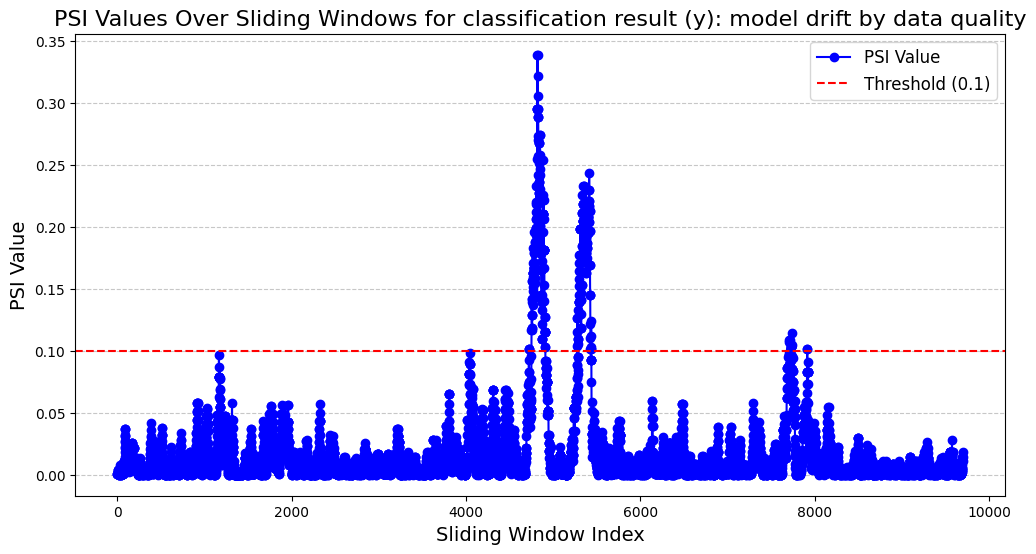

In [136]:
import matplotlib.pyplot as plt

# Assuming psi_values is already calculated
plt.figure(figsize=(12, 6))
plt.plot(range(len(psi_values)), psi_values, marker='o', linestyle='-', color='b', label='PSI Value')
plt.title('PSI Values Over Sliding Windows for classification result (y): model drift by data quality', fontsize=16)
plt.xlabel('Sliding Window Index', fontsize=14)
plt.ylabel('PSI Value', fontsize=14)
plt.axhline(y=0.1, color='r', linestyle='--', label='Threshold (0.1)')
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [137]:
len(y_pred)

154

In [138]:
values, counts = np.unique(y_pred, return_counts=True)
percents = counts/sum(counts)

# Print the results
for value, percentage in zip(values, percents):
    print(f"Value: {value}, Occurrence Percentage: {percentage:.2f}%")

Value: 0, Occurrence Percentage: 0.73%
Value: 1, Occurrence Percentage: 0.27%


In [139]:
def save_drift_output(X_test_drifted, y_test, y_pred, y_pred_drifted, filename):
    test_results = X_test_drifted.copy()
    test_results['true_label'] = y_test.values
    test_results['y_pred'] = y_pred
    test_results['y_pred_drifted'] = y_pred_drifted
    test_results.head()
    test_results.to_csv(filename, index=False)

def save_normal_output(X_test, y_test, y_pred, filename):
    test_results = X_test.copy()
    test_results['true_label'] = y_test.values
    test_results['y_pred'] = y_pred
    test_results.head()
    test_results.to_csv(filename, index=False)

In [140]:
outputfolder="output/diabetes"
save_normal_output(X_test, y_test, y_pred, f"{outputfolder}/normal_output.csv")
save_drift_output(X_test_drifted=X_test_drift,y_test=y_test,y_pred=y_pred,y_pred_drifted=y_pred_drift,filename=f"{outputfolder}/data_drift_output.csv")
save_drift_output(X_test_drifted=X_test_quality,y_test=y_test,y_pred=y_pred,y_pred_drifted=y_pred_quality,filename=f"{outputfolder}/data_quality_output.csv")


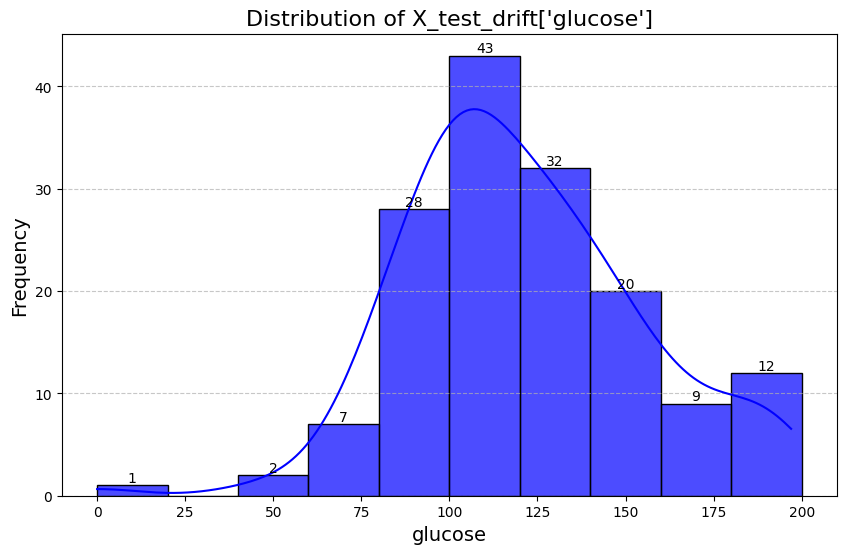

In [154]:

import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of 'pedigree'
plt.figure(figsize=(10, 6))
ax = sns.histplot(X_test['glucose'], kde=True, color='blue', alpha=0.7, bins=[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200], binrange=(0, 200))

# Annotate each bar with its height
for patch in ax.patches:
    height = patch.get_height()
    if height > 0:  # Only annotate bars with a height greater than 0
        ax.annotate(f'{int(height)}', 
                    (patch.get_x() + patch.get_width() / 2, height), 
                    ha='center', va='bottom', fontsize=10, color='black')

plt.title('Distribution of X_test_drift[\'glucose\']', fontsize=16)
plt.xlabel('glucose', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
1,0,2,7,28,43,32,20,9,12